In [1]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

In [2]:


def make_generator_model():
    target_dim = 16
    bd = target_dim // 4
    dense_size = 512
    
    model = tf.keras.Sequential()
    model.add(Dense(bd*bd*dense_size, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((bd, bd, dense_size)))
    assert model.output_shape == (None, bd, bd, dense_size) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, bd, bd, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, bd * 2, bd * 2, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, bd * 4, bd * 4, 1)

    return model

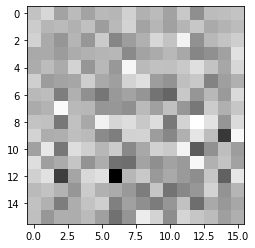

In [3]:
test_generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = test_generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [4]:
generated_image.shape

TensorShape([1, 16, 16, 1])

In [5]:
SIZE = 16
BATCH_SIZE = 32
EPOCHS = 60
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [6]:
test_matrix_unshaped = tf.constant([[((x + y) % 2.0) * 2 - 1 for x in range(SIZE)] for y in range(SIZE)])
test_matrix = tf.reshape(test_matrix_unshaped, [1, 16, 16])
test_matrix_unshaped

<tf.Tensor: shape=(16, 16), dtype=float32, numpy=
array([[-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.],
       [-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.],
       [-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.],
       [-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.],
       [-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
    

In [7]:
def calculate_loss_example(generated_images):
    return tf.reduce_sum(tf.multiply(tf.reshape(generated_images, [generated_images.shape[0], SIZE, SIZE]), test_matrix))

calculate_loss_example(generated_image)

<tf.Tensor: shape=(), dtype=float32, numpy=0.90468395>

In [8]:
scorer = tf.keras.models.load_model('models/scorer_1.model')

In [9]:
scorer(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[13.638681]], dtype=float32)>

In [10]:
def calculate_loss(generated_images):
    return -tf.reduce_sum(scorer(generated_images, training=True))

In [11]:
calculate_loss(generated_image)

<tf.Tensor: shape=(), dtype=float32, numpy=-13.638681>

In [12]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    # 1 - Generate images
    predictions = model(test_input, training=False)
    # 2 - Plot the generated images
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    # 3 - Save the generated images
    plt.savefig('out/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [15]:
generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step():
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        gen_loss = calculate_loss(generated_images)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


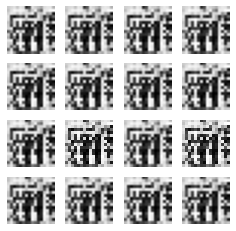

In [16]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(epochs):
    # A. For each epoch, do the following:
    for epoch in range(epochs):
        start = time.time()
        train_step()

        # 2 - Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # 3 - Save the model every 5 epochs as 
        # a checkpoint, which we will use later
    #     if (epoch + 1) % 5 == 0:
    #         checkpoint.save(file_prefix = checkpoint_prefix)

        # 4 - Print out the completed epoch no. and the time spent
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # B. Generate a final image after the training is completed
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    
train(200)